In [1]:
import astropy
import numpy as np
import pandas as pd
import scipy
import numpy
import pyspeckit
import zipfile
import os
import re
import matplotlib.pyplot as plt
from matplotlib import style
from astropy.table import QTable,Table,Column,MaskedColumn
from astropy.io import ascii
from sklearn.metrics import auc
from openpyxl import load_workbook
import xlrd
from tabulate import tabulate
import seaborn as sb
from scipy.stats import chisquare
import emcee

###

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def lectura(route):
    return Table.read(route,format='ascii')

def stof_list(lista):
    return [float(i) for i in lista]

def extinctions(tabla,extinction,cantidad):
    salida =[]
    if cantidad > 0:
        
        for N in range(1,cantidad+1):
            aux = [W['Magnitud']+(N*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad < 0:
        
        cantidad = round((cantidad**2)**(1/2))
        for M in range(0,cantidad+1):
            aux = [W['Magnitud'] - (M*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad == 0:
        salida.append([W['Magnitud'] for W in tabla])
        
    return salida

def colxfil(mat):
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2


def parametro_extincion(tabla,extinction,cantidad):
    salida =[]
    if cantidad > 0:
        
        for N in range(1,cantidad+1):
            aux = [(N*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad < 0:
        
        cantidad = round((cantidad**2)**(1/2))
        for M in range(0,cantidad+1):
            aux = [(M*float(extinction)) for W in tabla]
            salida.append(aux)
    
    if cantidad == 0:
        salida.append([extincion for W in tabla])
        
    return salida

def chi2(observed_point,expected_point):
    observed = ((observed_point[0])**(2)+(observed_point[1])**(2))**(1/2)
    expected = ((expected_point[0])**(2)+(expected_point[1])**(2))**(1/2)
    aux = (observed-expected)**(2)
    return aux/expected

def u(point1,point2):
    x2 = (point2[0] - point1[0])**(2)
    y2 = (point2[1] - point1[1])**(2)
    return np.sqrt(x2+y2)

def unique(lista):
    aux = []
    for i in lista:
        if i not in aux:
            aux.append(i)
    return aux

def limites(lista_color):
    return [(min(min(lista_color))),(max(max(lista_color)))]

def extremos(ejex,ejey):
    puntos_maximos_xy = [] #cada lista contiene por modelo puntos de los limites superiores e inferiores para construir una regresion
    puntos_minimos_xy = []
    for model,model2 in zip(ejex,ejey):
        aux_puntos_maximos = []
        aux_puntos_minimos = []
        #print(len(model),len(model2))
        #print('\n')
        for s,s2 in zip(model,model2):

            indice_maximo_s2 = s2.index(max(s2))
            #print(s[indice_s2],max(s2))
            punto_maximo=(s[indice_maximo_s2],max(s2))
            aux_puntos_maximos.append(punto_maximo)
        
            indice_minimo_s2 = s2.index(min(s2))
            punto_minimo = ((s[indice_minimo_s2],min(s2)))
            aux_puntos_minimos.append(punto_minimo)
        puntos_maximos_xy.append(aux_puntos_maximos)    
        puntos_minimos_xy.append(aux_puntos_minimos)
    return [puntos_maximos_xy,puntos_minimos_xy]

def rectas(x,y):
    X = np.array(x)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(
                                            X.reshape(-1,1),
                                            y.reshape(-1,1),
                                            train_size   = 0.5,
                                            random_state = 1234,
                                            shuffle      = True
                                        )
    modelo = LinearRegression()
    modelo.fit(X = X_train.reshape(-1, 1), y = y_train)
    return(float(modelo.coef_[0]),modelo.intercept_[0])

In [3]:
#datos fotometricos de Candidatos oficiales
routes = [f'candidatos/{alpha}' for alpha in os.listdir('candidatos') if alpha != '.DS_Store' and alpha !='filtrados' and alpha!='Select1.txt' and alpha!='Select2.txt' and alpha!='Extincion_candidatos']
names = [string[:(len(string)-4)] for string in os.listdir('candidatos') if string != '.DS_Store' and string !='filtrados' and string!='Select1.txt' and string!='Select2.txt' and string!='Extincion_candidatos']
tablas = [lectura(dato) for dato in routes]
tablas2 = [dato2[dato2['cl']=='3'] for dato2 in tablas]

us = [data['umag'] for data in tablas2]
gs = [data['gmag'] for data in tablas2]
rs = [data['rmag'] for data in tablas2]
i_s = [data['imag'] for data in tablas2]
zs = [data['zmag'] for data in tablas2]


ugs = [(stof_list(u),stof_list(g)) for u,g in zip(us,gs)]
grs = [(stof_list(g),stof_list(r)) for g,r in zip(gs,rs)]
gzs = [(stof_list(g),stof_list(z)) for g,z in zip(gs,zs)]
ris = [(stof_list(r),stof_list(i)) for r,i in zip(rs,i_s)]
izs = [(stof_list(i),stof_list(z)) for i,z in zip(i_s,zs)]
rzs = [(stof_list(r),stof_list(z)) for r,z in zip(rs,zs)]
urs = [(stof_list(u),stof_list(r)) for u,r in zip(us,rs)]

resta_ug = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in ugs]
resta_gr = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in grs]
resta_gz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in gzs]
resta_ri = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in ris]
resta_iz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in izs]
resta_rz = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in rzs]
resta_ur = [[ round(a-b,5) for a,b in zip(par_lista[0],par_lista[1])] for par_lista in urs]

ruta = 'Candidatos/Extincion_candidatos'
candidates = [181,202,520,1182,2782,4676]
extra = ['ARP','ARP','NGC','IC','NGC','NGC']
while ruta == 'Candidatos/Extincion_candidatos':
    print('Decide between:\n')
    print('· 181\n· 202\n· 520\n· 1182\n· 2782\n· 4676')
    try:
        R = int(input('>'))
        if R in candidates:
            tipo = candidates.index(R)
            ruta_out = f'{ruta}/extinctions_{extra[tipo]}_{R}.csv'
            ruta = ruta_out
        if R not in candidates:
            pass
    except(ValueError):
        pass

tabla_ext = ascii.read(ruta)
ext = tabla_ext['The Galactic extinction']
#ruta_hcg = f'Mag_hcg_600/Magnitudes hcg {R}'

Decide between:

· 181
· 202
· 520
· 1182
· 2782
· 4676
>181


Number of replications >35


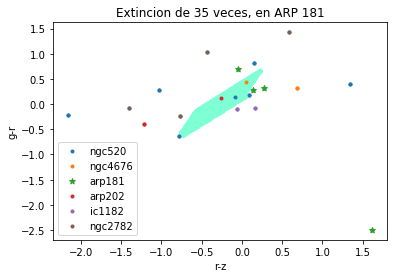

In [6]:
os.listdir('Magnitud/Instantaneas/Tidal 11') #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidal=12
output=3
route_u=f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt'
route_g=f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt'
route_r=f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt'
route_i=f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt'
route_z=f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt'

u=ascii.read(route_u)
g=ascii.read(route_g)
r=ascii.read(route_r)
i=ascii.read(route_i)
z=ascii.read(route_z)

ug = u['Magnitud']-g['Magnitud']
gr = g['Magnitud']-r['Magnitud']
gz = g['Magnitud']-z['Magnitud']
ri = r['Magnitud']-i['Magnitud']
iz = i['Magnitud']-z['Magnitud']
rz = r['Magnitud']-z['Magnitud']
ur = u['Magnitud']-r['Magnitud']

#en funcion de la extincion:
u_ext = [U['Magnitud']+float(ext[0]) for U in u] #1 extincion
g_ext = [G['Magnitud']+float(ext[1]) for G in g] #1 extincion
r_ext = [R['Magnitud']+float(ext[2]) for R in r] #1 extincion
i_ext = [I['Magnitud']+float(ext[3]) for I in i] #1 extincion
z_ext = [Z['Magnitud']+float(ext[4]) for Z in z] #1 extincion

ug_ext = [a-b for a,b in zip(u_ext,g_ext)]
gr_ext = [a-b for a,b in zip(g_ext,r_ext)]
gz_ext = [a-b for a,b in zip(g_ext,z_ext)]
ri_ext = [a-b for a,b in zip(r_ext,i_ext)]
rz_ext = [a-b for a,b in zip(r_ext,z_ext)]
ur_ext = [a-b for a,b in zip(u_ext,r_ext)]

#N cantidad de extinciones:
Numero = 0
while Numero == 0:
    try:
        Numero = int(input('Number of replications >'))
    except(valueError):
        pass

u_multi_ext = extinctions(u,ext[0],Numero)
g_multi_ext = extinctions(g,ext[1],Numero)
r_multi_ext = extinctions(r,ext[2],Numero)
i_multi_ext = extinctions(i,ext[3],Numero)
z_multi_ext = extinctions(z,ext[4],Numero)

ug_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(u_multi_ext,g_multi_ext)]
gr_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(g_multi_ext,r_multi_ext)]
gz_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(g_multi_ext,z_multi_ext)]
ri_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(r_multi_ext,i_multi_ext)]
rz_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(r_multi_ext,z_multi_ext)]
ur_multi_ext = [[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(u_multi_ext,r_multi_ext)]

color_candidatos = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
#graficando
for gr,rz,col,name in zip(resta_gr,resta_rz,color_candidatos,names): #data fotometrica canidatos confirmados, para "legend"
    if name == f'{extra[tipo].lower()}{R}':
        plt.scatter(rz,gr,marker='*', c=col )
    else:
        plt.scatter(rz,gr,marker='.', c=col )
    
plt.legend(names)

plt.scatter(rz,gr,marker='.',color='cyan') #modelo

if Numero > 0:
    for val in range(Numero):
        plt.scatter(rz_multi_ext[val],gr_multi_ext[val],marker='.',color='aquamarine')
        
if Numero < 0:
    Numero = round((Numero**2)**(1/2))
    for val in range(Numero):
        plt.scatter(rz_multi_ext[val],gr_multi_ext[val],marker='.',color='aquamarine')

if Numero == 0:
    pass

for gr,rz,col in zip(resta_gr,resta_rz,color_candidatos): #repeticion de data fotometrica canidatos confirmados, para visualizacion
    if name == f'{extra[tipo].lower()}{R}':
        plt.scatter(rz,gr,marker='*', c=col )
    else:
        plt.scatter(rz,gr,marker='.', c=col )


#plt.scatter(rz_hcg,gr_hcg,marker='.',color='g')
plt.title(f'Extincion de {Numero} veces, en {extra[tipo]} {R}')
plt.xlabel('r-z')
plt.ylabel('g-r')
#plt.xlim(-1,-0.5)
#plt.ylim(-1,0)

plt.show()

In [58]:
##### determinacion valores distancia #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidals = [10,11,12,16,17,18]
Outputs = ['',2,3,7,8,3]
routes_u = [f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_g = [f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_r = [f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_i = [f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_z = [f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]

tablas_u = [ascii.read(route_u) for route_u in routes_u] #tablas magnitud simulaciones
tablas_g = [ascii.read(route_g) for route_g in routes_g]
tablas_r = [ascii.read(route_r) for route_r in routes_r]
tablas_i = [ascii.read(route_i) for route_i in routes_i]
tablas_z = [ascii.read(route_z) for route_z in routes_z]

ug_general = [u['Magnitud']-g['Magnitud'] for u,g in zip(tablas_u,tablas_g)] 
gr_general = [g['Magnitud']-r['Magnitud'] for g,r in zip(tablas_g,tablas_r)]
gz_general = [g['Magnitud']-z['Magnitud'] for g,z in zip(tablas_g,tablas_z)]
ri_general = [r['Magnitud']-i['Magnitud'] for r,i in zip(tablas_r,tablas_i)]
iz_general = [i['Magnitud']-z['Magnitud'] for i,z in zip(tablas_i,tablas_z)]
rz_general = [r['Magnitud']-z['Magnitud'] for r,z in zip(tablas_r,tablas_z)]
ur_general = [u['Magnitud']-r['Magnitud'] for u,r in zip(tablas_u,tablas_r)]

edades = [age for age in range(100,1000+1,5)]
#Extinciones por data confirmada:
all_routes = ['Candidatos/Extincion_candidatos/extinctions_ARP_181.csv','Candidatos/Extincion_candidatos/extinctions_ARP_202.csv','Candidatos/Extincion_candidatos/extinctions_NGC_520.csv','Candidatos/Extincion_candidatos/extinctions_IC_1182.csv','Candidatos/Extincion_candidatos/extinctions_NGC_2782.csv','Candidatos/Extincion_candidatos/extinctions_NGC_4676.csv']
all_tables = [ascii.read(path) for path in all_routes]
all_extinctions = [table['The Galactic extinction'] for table in all_tables] #todas las extinciones


#for a,b in zip(all_routes,all_extinctions):
#    print(a,'\n',b)


#N cantidad de extinciones:
Numero = ''
while Numero == '':
    try:
        Numero = int(input('Number of replications >'))
    except(valueError):
        pass


for ext in all_extinctions:
    all_u_multi_ext = [extinctions(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_multi_ext = [extinctions(g,ext[1],Numero) for g in tablas_g]
    all_r_multi_ext = [extinctions(r,ext[2],Numero) for r in tablas_r]
    all_i_multi_ext = [extinctions(i,ext[3],Numero) for i in tablas_i]
    all_z_multi_ext = [extinctions(z,ext[4],Numero) for z in tablas_z]
    
    all_u_ext = [parametro_extincion(u,ext[0],Numero) for u in tablas_u] #una extincion sobre cada tabla
    all_g_ext = [parametro_extincion(g,ext[1],Numero) for g in tablas_g]
    all_r_ext = [parametro_extincion(r,ext[2],Numero) for r in tablas_r]
    all_i_ext = [parametro_extincion(i,ext[3],Numero) for i in tablas_i]
    all_z_ext = [parametro_extincion(z,ext[4],Numero) for z in tablas_z]


all_ug_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_g_multi_ext)]
all_gr_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_r_multi_ext)]
all_gz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_multi_ext,all_z_multi_ext)]
all_ri_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_i_multi_ext)]
all_rz_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_multi_ext,all_z_multi_ext)]
all_ur_multi_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_multi_ext,all_r_multi_ext)]

all_ug_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_g_ext)]
all_gr_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_r_ext)]
all_gz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_g_ext,all_z_ext)]
all_ri_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_i_ext)]
all_rz_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_r_ext,all_z_ext)]
all_ur_ext = [[[value1-value2 for value1,value2 in zip(a,b)] for a,b in zip(alpha,beta)] for alpha,beta in zip(all_u_ext,all_r_ext)]
#cada par de colores me entrega un punto (coordennadas), simulacion

X_confirmado = []
Y_confirmado = []
for a,b,name in zip(resta_gr,resta_rz,names): #datos confirmado: filtro por tipo unico
    #if f'{extra[tipo].lower()}{R}'==name:
    aux = []
    aux2 = []
    for m,n in zip(a,b):
        aux.append(m)
        aux2.append(n)
    X_confirmado.append(aux) #largo 6 por los tipos
    Y_confirmado.append(aux2)

X_simulation = []
Y_simulation = []
X_extincion = []
Y_extincion = []
ID_edad = []
indice_simulacion = []
for a,b,ae,be in zip(all_gr_multi_ext,all_rz_multi_ext,all_gr_ext,all_rz_ext):
    gr_ind = all_gr_multi_ext.index(a) #indice de la simulacion
    rz_ind = all_rz_multi_ext.index(b)
    for m,n,me,ne in zip(a,b,ae,be):
        for x,y,xe,ye,age in zip(m,n,me,ne,edades):
            X_simulation.append(x)
            Y_simulation.append(y)
            X_extincion.append(xe)
            Y_extincion.append(ye)
            ID_edad.append(age)
            indice_simulacion.append([gr_ind,rz_ind])
            
all_chi = []
for coord_x_real_list,coord_y_real_list,name in zip(X_confirmado,Y_confirmado,names):
    por_confirmado = []
    for coord_x_real,coord_y_real in zip(coord_x_real_list,coord_y_real_list):
        point_real_aux = [coord_x_real,coord_y_real]
        alpha = []
        for coord_x_sim,coord_y_sim,coord_x_extincion,coord_y_extincion,age,ID in zip(X_simulation,Y_simulation,X_extincion,Y_extincion,ID_edad,indice_simulacion):
            point_sim_aux = [coord_x_sim,coord_y_sim]
            c2 = chi2(point_real_aux,point_sim_aux) 
            alpha.append([c2,age,name,ID,point_real_aux,point_sim_aux,round(coord_x_extincion,5),round(coord_y_extincion,5)])#chi2,edad,grupo,id,punto_real,punto_simulado, extincion gr, extincion rz
        por_confirmado.append(alpha)
    all_chi.append(por_confirmado)

new_out = []
for chis,nam in zip(all_chi,names):
    for chi in chis:
        new_out.append((chi)) 
print('Ready to go!')

Number of replications >30


TypeError: 'int' object is not iterable

In [ ]:
#chi2:0 , edad:1, grupo:2, id:3, punto_real:4, punto_simulado:5 , extinciones: 6 y 7
Save = Table()

chi2_ =[]
edad_ =[]
grupo_ =[]
id_simulacion_ =[]
punto_real_x =[]
punto_real_y =[]
punto_simulado_x =[]
punto_simulado_y =[]
extincion_x = []
extincion_y = []
for data3 in new_out:

    for data2 in data3:
        chi2_.append(data2[0])
        edad_.append(data2[1])
        grupo_.append(data2[2])
        id_simulacion_.append(data2[3][0])
        punto_real_x.append(data2[4][0])
        punto_real_y.append(data2[4][1])
        punto_simulado_x.append(data2[5][0])
        punto_simulado_y.append(data2[5][1])
        extincion_x.append(data2[6])
        extincion_y.append(data2[7])

Save['Grupo'] = grupo_
Save['ID'] = id_simulacion_
Save['Edad'] = edad_
Save['Chi2'] = chi2_
Save['gr Real'] = punto_real_x
Save['rz Real'] = punto_real_y
Save['gr Simulado'] = punto_simulado_x
Save['rz Simulado'] = punto_simulado_y
Save['gr extincion'] = extincion_x
Save['rz extincion'] = extincion_y


In [59]:
Save

Grupo,ID,Edad,Chi2,gr Real,rz Real,gr Simulado,rz Simulado,gr extincion,rz extincion
str7,int64,int64,float64,float64,float64,float64,float64,float64,float64
ngc520,0,100,0.004450977215387842,-0.631,-0.776,-0.6573205498612733,-0.8432179018007862,0.017,0.017
ngc520,0,105,0.004027750266762893,-0.631,-0.776,-0.6526886410326949,-0.8424252898756954,0.017,0.017
ngc520,0,110,0.003337300472440979,-0.631,-0.776,-0.6465564813185711,-0.8395189343202016,0.017,0.017
ngc520,0,115,0.0029441409586304325,-0.631,-0.776,-0.6415102445950982,-0.8387146554713052,0.017,0.017
ngc520,0,120,0.0022763205048118144,-0.631,-0.776,-0.63435846946102,-0.8355021508895106,0.017,0.017
ngc520,0,125,0.0017312587462591951,-0.631,-0.776,-0.6273973976977345,-0.8327676728643283,0.017,0.017
ngc520,0,130,0.0012120658809104514,-0.631,-0.776,-0.6202444106035205,-0.8293123502603503,0.017,0.017
ngc520,0,135,0.000845113764828516,-0.631,-0.776,-0.6142891941383315,-0.8263557018939913,0.017,0.017
ngc520,0,140,0.0005059090561477527,-0.631,-0.776,-0.6080726786338104,-0.8225613494545918,0.017,0.017


In [60]:
model = [0,1,2,3,4,5]
por_grupo = [[] for nam in model]
for li,nam in zip(por_grupo,model):
    aux = []
    for group in Save:
        if group['ID']==nam:
            aux.append((group['Grupo'],group['Edad'],group['Chi2'],group['gr Simulado'],group['rz Simulado'],group['gr extincion'],group['rz extincion']))
    li.append(colxfil(aux))

In [61]:
print(Numero)
new_gr = ((gr_general)*Numero)*21
new_rz = ((rz_general)*Numero)*21
len(new_gr[0])*len(new_gr)

30


684180

In [62]:
PG = [Table() for i in por_grupo]

for tab,li in zip(PG,por_grupo): #revisar si el orden en que se evaluan los modelos esta bien
    c=0
    rgr = []
    rrz = []
    for lis in li:

        tab['Grupo'] = lis[0]
        tab['Edad'] = lis[1]
        tab['chi2'] = lis[2]
        tab['gr S'] = lis[3]
        tab['rz S'] = lis[4]
        for real_gr,real_rz in zip(lis[3],lis[4]):
            if c>=181:
                pass
            else:
                rgr.append(real_gr)
                rrz.append(real_rz)
            c+=1
        u = int(len(lis[3])/len(rgr))
        tab['gr R'] = u*(rgr)
        tab['rz R'] = u*(rrz)
        tab['ext gr'] = lis[5]
        tab['ext rz'] = lis[6]
#PG[0]
        tab['Vector u'] = np.sqrt(((tab['gr S']-tab['gr R'])**2)+((tab['rz S']-tab['rz R'])**2))
        tab['N'] = (Numero*tab['Vector u'])/max(tab['Vector u'])
        
        

In [63]:
Numero

30

In [64]:
N = []
model = [0,1,2,3,5,4]
for pg,n in zip(PG,model):
    print(f'Modelo {n}')
    pg = pg[pg['Vector u']>0] #mientras el vector sea mayor a 1 repeticion
    pg = pg[pg['chi2']==min(pg['chi2'])] #mientras sea el mejor ajuste
    N.append(pg['N'][0]) #guardar N
    print(pg['Vector u'],'\n')


Modelo 0
     Vector u     
------------------
0.5529575028878815 

Modelo 1
      Vector u     
-------------------
0.28849956672411226 

Modelo 2
     Vector u     
------------------
0.5048742417671965 

Modelo 3
     Vector u     
------------------
0.5529575028878815 

Modelo 5
     Vector u     
------------------
0.5048742417671965 

Modelo 4
     Vector u     
------------------
0.6972072862499363 



In [65]:
N = [round(n) for n in N] #N calibrado
N

[20, 11, 19, 20, 19, 26]

In [66]:
(os.listdir('CAT_HCG_600'))

['Catálogo hcg 2','Catálogo hcg 6','Catálogo hcg 7','Catálogo hcg 16','Catálogo hcg 22','Catálogo hcg 26','Catálogo hcg 31','Catálogo hcg 89','Catálogo hcg 96','Catálogo hcg 100']

['Catálogo hcg 2',
 'Catálogo hcg 6',
 'Catálogo hcg 7',
 'Catálogo hcg 16',
 'Catálogo hcg 22',
 'Catálogo hcg 26',
 'Catálogo hcg 31',
 'Catálogo hcg 89',
 'Catálogo hcg 96',
 'Catálogo hcg 100']

In [67]:
###### determinacion valores distancia #tidal-output: 11-2, 12-3, 13-4, 14-5, 15-6, 16-7, 17-8, 18-3
Tidals = [10,11,12,16,17,18]
Outputs = ['',2,3,7,8,3]
routes_u = [f'Magnitud/Instantaneas/Tidal {Tidal}/U_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_g = [f'Magnitud/Instantaneas/Tidal {Tidal}/G_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_r = [f'Magnitud/Instantaneas/Tidal {Tidal}/R_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_i = [f'Magnitud/Instantaneas/Tidal {Tidal}/I_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]
routes_z = [f'Magnitud/Instantaneas/Tidal {Tidal}/Z_Seba_output {output}.txt' for Tidal, output in zip(Tidals,Outputs)]

tablas_u = [ascii.read(route_u) for route_u in routes_u] #tablas magnitud simulaciones
tablas_g = [ascii.read(route_g) for route_g in routes_g]
tablas_r = [ascii.read(route_r) for route_r in routes_r]
tablas_i = [ascii.read(route_i) for route_i in routes_i]
tablas_z = [ascii.read(route_z) for route_z in routes_z]

ug_general = [u['Magnitud']-g['Magnitud'] for u,g in zip(tablas_u,tablas_g)]  #colores simulacion
gr_general = [g['Magnitud']-r['Magnitud'] for g,r in zip(tablas_g,tablas_r)]
gz_general = [g['Magnitud']-z['Magnitud'] for g,z in zip(tablas_g,tablas_z)]
ri_general = [r['Magnitud']-i['Magnitud'] for r,i in zip(tablas_r,tablas_i)]
iz_general = [i['Magnitud']-z['Magnitud'] for i,z in zip(tablas_i,tablas_z)]
rz_general = [r['Magnitud']-z['Magnitud'] for r,z in zip(tablas_r,tablas_z)]
ur_general = [u['Magnitud']-r['Magnitud'] for u,r in zip(tablas_u,tablas_r)]

edades = [age for age in range(100,1000+1,5)]

#####
#tablas catalogos hcg
#####

catalogos = ['Catálogo hcg 2','Catálogo hcg 6','Catálogo hcg 7','Catálogo hcg 16','Catálogo hcg 22','Catálogo hcg 26','Catálogo hcg 31','Catálogo hcg 89','Catálogo hcg 96','Catálogo hcg 100']
HCG = [2, 6, 7, 16, 22, 26, 31, 89, 96, 100]
Tablas_hcg= [ascii.read(f'CAT_HCG_600/{route}') for route in catalogos if route != '.DS_Store'] 

#uso de datos
g_cat_tables = [table['m_g'] for table in Tablas_hcg]
r_cat_tables = [table['m_r'] for table in Tablas_hcg]
z_cat_tables = [table['m_z'] for table in Tablas_hcg]
ra_cat_tables = [table['ra'] for table in Tablas_hcg]
dec_cat_tables = [table['dec'] for table in Tablas_hcg]
ext_cat = [table['ebv'] for table in Tablas_hcg]

extin_cat = ['extinctions_hcg_2.csv','extinctions_hcg_6.csv','extinctions_hcg_7.csv','extinctions_hcg_16.csv','extinctions_hcg_22.csv','extinctions_hcg_26.csv','extinctions_hcg_31.csv','extinctions_hcg_89.csv','extinctions_hcg_96.csv','extinctions_hcg_100.csv']
all_cat_ext = [f'Extinction/{w}' for w in extin_cat if w!='.DS_Store']
all_cat_extinction_tables = [(ascii.read(f'{w2}'))['The Galactic extinction'] for w2 in all_cat_ext]



for ext in all_cat_extinction_tables: #una extincion sobre cada tabla; ext[0]=u,ext[1]=g,ext[2]=r,ext[3]=i,ext[4]=z

    all_g_cat_ext = [extinctions(g,ext[1],int(n)) for g,n in zip(tablas_g,N)] #extincion N veces
    all_r_cat_ext = [extinctions(r,ext[2],int(n)) for r,n in zip(tablas_r,N)]
    all_z_cat_ext = [extinctions(z,ext[4],int(n)) for z,n in zip(tablas_z,N)]
    
gr_cat_tables = [g-r for g,r in zip(g_cat_tables,r_cat_tables)] #datos fotometricos
rz_cat_tables = [r-z for r,z in zip(r_cat_tables,z_cat_tables)]

all_gr_cat_ext = [[[g-r for g,r in zip(ge,re)] for ge,re in zip(eg,er)] for eg,er in zip(all_g_cat_ext,all_r_cat_ext)]
all_rz_cat_ext = [[[r-z for r,z in zip(re,ze)] for re,ze in zip(er,ez)] for er,ez in zip(all_r_cat_ext,all_z_cat_ext)]
#colores de simulaciones N veces -> enrojecimiento!!!!!!!!


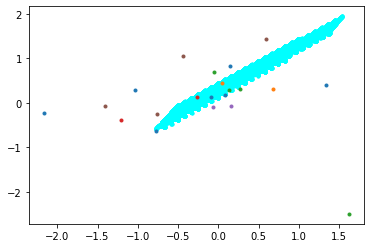

In [68]:
for a,b in zip(all_gr_cat_ext,all_rz_cat_ext):
    
    plt.scatter(b,a,marker='.',c='cyan')
    
for gr,rz,col in zip(resta_gr,resta_rz,color_candidatos): #repeticion de data fotometrica canidatos confirmados, para visualizacion
    if name == f'{extra[tipo].lower()}{R}':
        plt.scatter(rz,gr,marker='*', c=col )
    else:
        plt.scatter(rz,gr,marker='.', c=col )
plt.show()

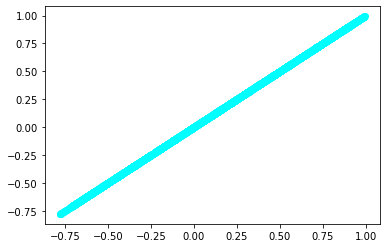

In [69]:
model = 0
plt.scatter(all_rz_cat_ext[model] ,all_rz_cat_ext[model],marker='o', color ='cyan')
plt.show()

In [70]:
for a,b in zip(all_gr_cat_ext ,all_rz_cat_ext):
    print(max(max(a)),max(max(b)))

1.3414286814097682 0.9936262539725611
0.698232437407901 0.2911476970090039
1.440537668675379 1.0001007002905125
1.341429648680446 0.9936252917323003
1.4405377393594492 1.0001005945403243
1.9432315377407328 1.536149058354562


In [71]:
os.listdir('Extinction')

['extinctions_hcg_96.csv',
 'extinctions_hcg_100.csv',
 'extinctions_hcg_22.csv',
 'extinctions_hcg_31.csv',
 'extinctions_hcg_26.csv',
 'extinctions_hcg_16.csv',
 'extinctions_hcg_2.csv',
 'extinctions_hcg_7.csv',
 'extinctions_hcg_6.csv',
 'extinctions_hcg_89.csv']

[]

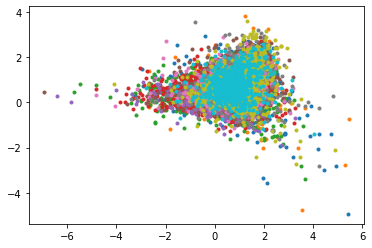

In [72]:
for a,b in zip(gr_cat_tables,rz_cat_tables):

    plt.scatter(b,a,marker='.')
plt.plot()

In [73]:
#limitar datos reales en base a parametros de simulacion, cuadrado
lim_gr = []
lim_rz = []
for gr_,rz_ in zip(all_gr_cat_ext,all_rz_cat_ext):

    lim_gr.append(limites(gr_)) #me marca el punto maximo y minimo en cada eje por simulacion
    lim_rz.append(limites(rz_)) ### 1 simulacion -> 4 ptos extremos 



In [74]:
#guardando datos en tablas reduciendo a cuandrados alrededor del modelo, aqui podria estar el problema

###
### El error podria estar asociado aqui
###
gnr_out = []


for limg,limz in zip(lim_gr,lim_rz):
    aux=[]
    for g,z,ra,dec in zip(gr_cat_tables,rz_cat_tables,ra_cat_tables,dec_cat_tables):
        
        Test = Table() 
        Test['gr'] = g
        Test['rz'] = z
        Test['RA'] = ra
        Test['DEC'] = dec
    

        Test['limg 1'] = [limg[0] for line in range(len(Test))]
        Test['limg 2'] = [limg[1] for line in range(len(Test))]
        Test['limz 1'] = [limz[0] for line in range(len(Test))]
        Test['limz 2'] = [limz[1] for line in range(len(Test))]
    
        Test = Test[Test['gr']>Test['limg 1']]
        Test = Test[Test['gr']<Test['limg 2']]
        Test = Test[Test['rz']>Test['limz 1']]
        Test = Test[Test['rz']<Test['limz 2']]
        aux.append(Test)
    gnr_out.append(aux)
 
  

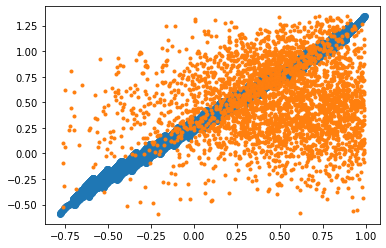

In [75]:
#grafiico limites de datos en cuadrado
k=3
plt.scatter(((all_rz_cat_ext[k])),(all_gr_cat_ext[k]))
#plt.scatter(all_rz_cat_ext[k],all_gr_cat_ext[k])
plt.scatter(gnr_out[k][4]['rz'],gnr_out[k][4]['gr'],marker='.')
plt.show()

In [76]:
#limites para rectangulo -> puntos para regresiones
simulaciones_cat_ext_maximos = (extremos(all_rz_cat_ext,all_gr_cat_ext)[0]) #puntos de limites sup e inf de los modelos
simulaciones_cat_ext_minimos = (extremos(all_rz_cat_ext,all_gr_cat_ext)[1]) #para regresion

simulaciones_base = [[(l,l2) for l,l2 in zip(lista[0],lista2[0])] for lista,lista2 in zip(all_rz_cat_ext,all_gr_cat_ext)] #limites horizontales para regresion
simulaciones_finales = [[(l,l2) for l,l2 in zip(lista[len(lista)-1],lista2[len(lista2)-1])] for lista,lista2 in zip(all_rz_cat_ext,all_gr_cat_ext)]

In [77]:
rectangulos = [] #debe almacenar los coeficientes (coef_,intercept_) de las rectas de los 4 lados por modelo (5)
for shemax,shemin,sbase,sfin in zip(simulaciones_cat_ext_maximos,simulaciones_cat_ext_minimos,simulaciones_base,simulaciones_finales):
    x_shemax = []
    x_shemin = []
    x_sbase = []
    x_sfin = []
    
    y_shemax = []
    y_shemin = []
    y_sbase = []
    y_sfin = []
    
    for v_shemax,v_shemin,v_sbase,v_sfin in zip(shemax,shemin,sbase,sfin): #aqui no es el problema
        if len(shemax)==2:
            print(v_sbase)
        x_shemax.append(v_shemax[0])
        x_shemin.append(v_shemin[0])
        x_sbase.append(v_sbase[0])
        x_sfin.append(v_sfin[0])
        y_shemax.append(v_shemax[1])
        y_shemin.append(v_shemin[1])
        y_sbase.append(v_sbase[1])
        y_sfin.append(v_sfin[1])
        
    rect_shemax = rectas(x_shemax,y_shemax)
    rect_shemin = rectas(x_shemin,y_shemin)
    rect_sbase = rectas(x_sbase,y_sbase)
    rect_sfin = rectas(x_sfin,y_sfin)
    
    rectangulos.append([rect_sbase,rect_shemax,rect_sfin,rect_shemin])
    

In [78]:
#egregando pendiente y punto de interseccion de las curvas de regresion por modelo
puntos_dentro_cat = []

c=0
for modelo,m in zip(gnr_out,rectangulos): #aqui no deberia ser el problema
    por_modelo = []
    for aux_Tab in (modelo):

        aux_Tab['bl'] = [m[0][0] for l in range(len(aux_Tab))]
        aux_Tab['bl i'] = [m[0][1] for l in range(len(aux_Tab))]
                
        aux_Tab['mx'] = [m[1][0] for l in range(len(aux_Tab))]
        aux_Tab['mx i'] = [m[1][1] for l in range(len(aux_Tab))]
                
        aux_Tab['rl'] = [m[2][0] for l in range(len(aux_Tab))]
        aux_Tab['rl i'] = [m[2][1] for l in range(len(aux_Tab))]
                
        aux_Tab['mn'] = [m[3][0] for l in range(len(aux_Tab))]
        aux_Tab['mn i'] = [m[3][1] for l in range(len(aux_Tab))]
        
        
        
        por_modelo.append(aux_Tab)
 
    puntos_dentro_cat.append(por_modelo)
          

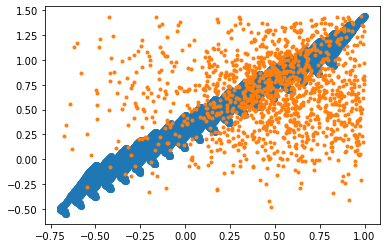

In [79]:
grou=6
mode=4
plt.scatter(all_rz_cat_ext[mode],all_gr_cat_ext[mode])
plt.scatter(gnr_out[mode][grou]['rz'],gnr_out[mode][grou]['gr'],marker='.')
plt.show()

In [80]:
#filtrado de datos en base a los rectangulos de regresion
all_out = []
c=0
for modelo in puntos_dentro_cat:
    c+=1
    mdl = []
    for table_group in modelo: #table_group -> grupo

        table_group['baseline'] = (table_group['bl']*table_group['rz'])+(table_group['bl i']) 
        table_group['redline'] = (table_group['rl']*table_group['rz'])+(table_group['rl i'])
    
        table_group['mxl'] = (table_group['mx']*table_group['rz'])+(table_group['mx i'])#ecuacion recta de regresion, puntos maximos
        table_group['mnl'] = (table_group['mn']*table_group['rz'])+(table_group['mn i'])#ecuacion recta de regresion, puntos minimos
    
        #table_group = table_group[table_group['gr']>table_group['baseline']]
        #table_group = table_group[table_group['gr']<table_group['redline']]
    
        table_group = table_group[table_group['gr']<table_group['mxl']]
        table_group = table_group[table_group['gr']>table_group['mnl']]
        
        #table_group = table_group[table_group['gr']<table_group['redline']]
        #table_group = table_group[table_group['gr']>table_group['baseline']]
        
        mdl.append(table_group)
    all_out.append(mdl)
    print(c)
all_out = colxfil(all_out) #cambia orden de modelo->grupos a grupos->modelo

1
2
3
4
5
6


In [81]:
#guarda coordenadas por grupos y por modelo.

hcg = [2,6,7,16,22,26,31,89,96,100]
for group,hc_g in zip(all_out,hcg): #por grupo y nombre de grupos
    for model,name in zip(group,[0,1,2,3,5,4]): #por modelo y tipo de modelo
        model2 = Table() #guardado de datos
        model2['RA'] = model['RA']
        model2['DEC'] = model['DEC']
        quant = len(model2)
        #model2.write(f'coords_finales/cooordenadas_HCG{hc_g}_modelo{name}',format='ascii',overwrite = True)
        print(f'Cantidad en hcg {hc_g} modelo {name}: {len(model2)} ')

Cantidad en hcg 2 modelo 0: 375 
Cantidad en hcg 2 modelo 1: 119 
Cantidad en hcg 2 modelo 2: 783 
Cantidad en hcg 2 modelo 3: 375 
Cantidad en hcg 2 modelo 5: 783 
Cantidad en hcg 2 modelo 4: 558 
Cantidad en hcg 6 modelo 0: 108 
Cantidad en hcg 6 modelo 1: 29 
Cantidad en hcg 6 modelo 2: 200 
Cantidad en hcg 6 modelo 3: 108 
Cantidad en hcg 6 modelo 5: 200 
Cantidad en hcg 6 modelo 4: 145 
Cantidad en hcg 7 modelo 0: 742 
Cantidad en hcg 7 modelo 1: 339 
Cantidad en hcg 7 modelo 2: 1497 
Cantidad en hcg 7 modelo 3: 742 
Cantidad en hcg 7 modelo 5: 1497 
Cantidad en hcg 7 modelo 4: 1024 
Cantidad en hcg 16 modelo 0: 663 
Cantidad en hcg 16 modelo 1: 278 
Cantidad en hcg 16 modelo 2: 1341 
Cantidad en hcg 16 modelo 3: 663 
Cantidad en hcg 16 modelo 5: 1341 
Cantidad en hcg 16 modelo 4: 939 
Cantidad en hcg 22 modelo 0: 476 
Cantidad en hcg 22 modelo 1: 189 
Cantidad en hcg 22 modelo 2: 916 
Cantidad en hcg 22 modelo 3: 476 
Cantidad en hcg 22 modelo 5: 916 
Cantidad en hcg 22 modelo 4:

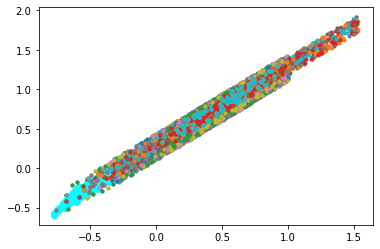

In [82]:

plt.scatter(all_rz_cat_ext[0],all_gr_cat_ext[0],color='cyan')
for i in (all_out):
    for j in i:
        plt.scatter(j['rz'],j['gr'],marker='.')
        


plt.show()

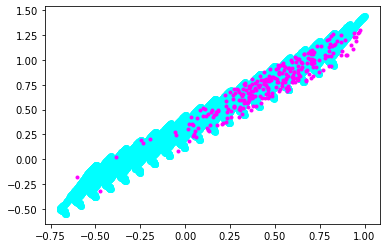

In [83]:
#filtrado final 
grou=[0,1,2,3,4,5,6,7,8,9]
mode=4
plt.scatter(all_rz_cat_ext[mode],all_gr_cat_ext[mode],color='cyan')  #all_gr_cat_ext -> modelos en corrimiento

plt.scatter(all_out[8][mode]['rz'],all_out[8][mode]['gr'],marker='.',c='magenta')
plt.show()

In [84]:
d=0
modelo = [0,1,2,3,5,4]
for a,b,m in zip(simulaciones_base,simulaciones_finales,modelo):

    d=0
    if d==0:

        dist = round(np.sqrt((b[0][0]-a[0][0])**(2)+(b[0][1]-a[0][1])**(2)),4)
        print(f'Modelo {m} Vector u: {dist}')
    d+=1

Modelo 0 Vector u: 2.2302
Modelo 1 Vector u: 1.1738
Modelo 2 Vector u: 2.1128
Modelo 3 Vector u: 2.2302
Modelo 5 Vector u: 2.1128
Modelo 4 Vector u: 2.9345


In [85]:
1.4086/np.sqrt(2)

0.9960306119793708

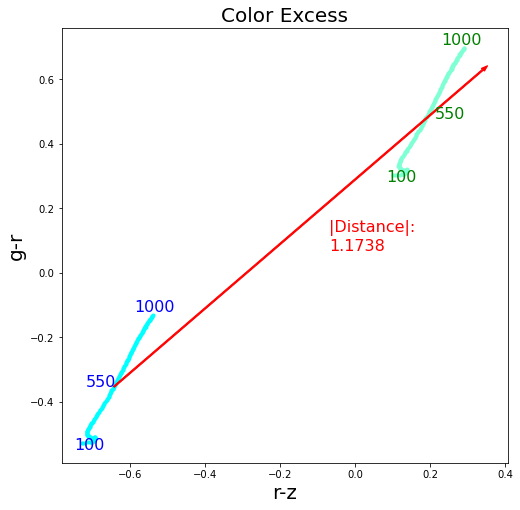

In [86]:
#grafico corrimiento-> flecha 
d=0
plt.figure(figsize=(8,8))
for a,b,age in zip(simulaciones_base[1],simulaciones_finales[1],edades): #datos de simulacion azul y verde
    if d==0: #texto de 100 Myr
        #print(a[0])
        plt.text(a[0]-0.02,a[1]-0.02,age,color='blue',fontsize=16) 
        plt.text(b[0]-0.02,b[1]-0.02,age,color='g',fontsize=16)
        
    if d==180: #texto de 1 Gyr
        plt.text(a[0]-0.05,a[1]+0.01,age,color='blue',fontsize=16)
        plt.text(b[0]-0.06,b[1]+0.01,age,color='g',fontsize=16)
        
    if round((len(simulaciones_base[0])-1)/2)==d: #texto de 550 Myr y construccion de la flecha
        dist = f'|Distance|:\n{round(np.sqrt((b[0]-a[0])**(2)+(b[1]-a[1])**(2)),4)}'
        
        plt.arrow(a[0],a[1],0.9960306119793708,0.9960306119793708,width=0.004,length_includes_head=True,color='red')
        
        plt.text(a[0]+(0.9960306119793708/2)+0.075,a[1]+(0.9960306119793708/2)-0.075,dist,color='red',fontsize=16)
        plt.text(a[0]-0.075,a[1],age,color='blue',fontsize=16)
        plt.text(b[0]+0.025,b[1],age,color='g',fontsize=16)
        
    plt.scatter(a[0],a[1],marker='.',color='cyan') #simulacion azul
    plt.scatter(b[0],b[1],marker='.',color='aquamarine') #simulacion verde
    
    d+=1
plt.title('Color Excess',fontsize=20)
plt.xlabel('r-z',fontsize=20)
plt.ylabel('g-r',fontsize=20)
plt.savefig('Red.png',format='png')
plt.show()

[2, 6, 7, 16, 22, 26, 31, 89, 96, 100]

In [87]:
hcg = [2,6,7,16,22,26,31,89,96,100]
por_c=[]

only_val = []
for names,i in zip(hcg,all_out):
    c=0
    s=0
    for j in i:
        
        s+=1
        c+=len(j)
        if len(j)==0:
            pass
        else:
            pass
            #print(f'El cruce del conjunto de datos de HCG {names} con el modelo {s}: {len(j)}')
    por_c.append(f'HCG {names} contiene {int(c/2)} objetos, entre las 5 simulaciones (combinadas)')
    only_val.append(int(c/2))

por_c

['HCG 2 contiene 1496 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 6 contiene 395 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 7 contiene 2920 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 16 contiene 2612 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 22 contiene 1814 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 26 contiene 688 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 31 contiene 722 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 89 contiene 467 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 96 contiene 554 objetos, entre las 5 simulaciones (combinadas)',
 'HCG 100 contiene 271 objetos, entre las 5 simulaciones (combinadas)']

In [88]:
only_val

[1496, 395, 2920, 2612, 1814, 688, 722, 467, 554, 271]

In [89]:
hcg = [2,6,7,16,22,26,31,89,96,100]
z_ = ['Z=0.008','Z=0.02','Z=0.05']
m_ = ['$10^6$','$10^8$']
zm = []
for m in m_:
    for z in z_:
        zm.append((m,z))
zm = [('$10^6$', 'Z=0.008'), #ver orden de los subtitulos de la imagen final aqui en "zm"
 ('$10^6$', 'Z=0.02'),
 ('$10^6$', 'Z=0.05'),
 ('$10^8$', 'Z=0.008'),
 ('$10^8$', 'Z=0.05'),
 ('$10^8$', 'Z=0.02')]

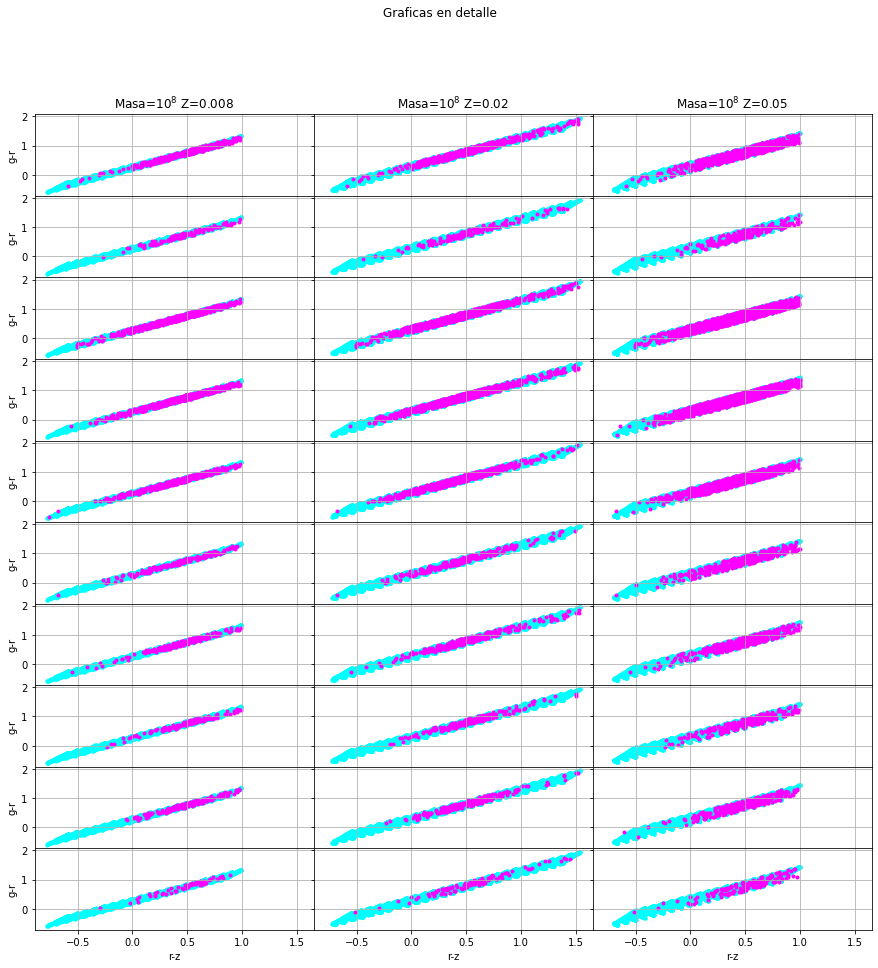

In [90]:
#grafico final

hcg__f = [i for i in range(0,len(hcg))]
model__f = [3,5,4]
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(10, 3, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

fig.suptitle('Graficas en detalle')
c=0
s=0

for hf in hcg__f: #por grupo en hcg_f 
    c=0
    for mf in (model__f): #por modelo en model_f
        axs[s,c].scatter(all_rz_cat_ext[mf],all_gr_cat_ext[mf],marker='.',c='cyan') #all_gr_cat_ext -> modelos en corrimiento

        axs[s,c].scatter(all_out[hf][mf]['rz'],all_out[hf][mf]['gr'],marker='.',c='magenta') #datos reducidos
        if s==0:
            axs[s,c].set_title(f'Masa={zm[mf][0]} {zm[mf][1]}')
        axs[s,c].grid()
        c+=1
    s+=1
    
#plt.title(f'HCG {hcg[hcg__]} con modelo {identificador_sim[model__]}')

for ax in axs.flat:

    ax.set(xlabel='r-z', ylabel='g-r')
for ax in axs.flat:
    ax.label_outer()

plt.savefig('Test_02.png',format='png')
plt.show()

In [53]:
#models: 3,5,4 for each hcg, all_out[hcg][model]

[24, 12, 22, 24, 22, 30]

In [133]:
tabu = []
for typee,name in zip(hcg__f,hcg):
    cx = []
    for mmm in model__f:
        aux_t = Table()
        
        aux_t['HCG'] = [name for i in range(len(all_out[typee][mmm]['RA']))]
        aux_t['Simodel'] = [mmm for i in range(len(all_out[typee][mmm]['RA']))]
        
        aux_t['RA'] = all_out[typee][mmm]['RA']
        aux_t['DEC'] = all_out[typee][mmm]['DEC']
        
        cx.append(aux_t)
    tabu.append(cx)

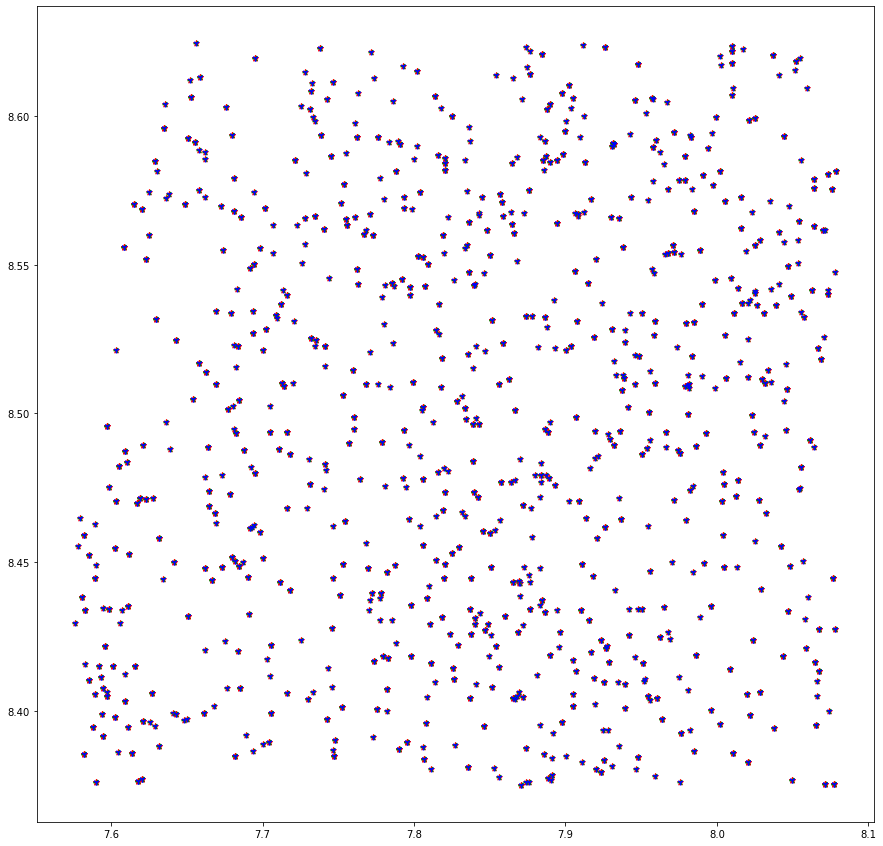

In [134]:
fig = plt.figure(figsize=(15,15))
for typee in [0]:
    for mmm in [0,1,2]:
        plt.scatter(tabu[typee][mmm]['RA'],tabu[typee][mmm]['DEC'], color='r',marker = '*')
        plt.scatter(tabu[typee][mmm]['RA'],tabu[typee][mmm]['DEC'], color='g',marker = '3')
        plt.scatter(tabu[typee][mmm]['RA'],tabu[typee][mmm]['DEC'], color='b',marker = '1')
plt.show()

In [136]:
tabu

[[<Table length=375>
   HCG  Simodel         RA                DEC       
  int64  int64       float64            float64     
  ----- ------- ------------------ -----------------
      2       3  7.581014585368665 8.438316429440523
      2       3  7.582074613487595 8.385490754026533
      2       3  7.582366517726918 8.459194431027521
      2       3   7.58272608756755 8.433879457889715
      2       3  7.585335839367654 8.410434004929243
      2       3 7.5853603043724664 8.452389545621644
      2       3  7.588245233783938 8.394691154403668
      2       3 7.5896897408666195 8.444560833978032
      2       3   7.59016015969087 8.375953134783902
      2       3  7.591865974925467  8.41520039561695
      2       3  7.594696968672174 8.391454190653018
      2       3  7.595708375894067 8.421895879971817
      2       3  7.597175599577403 8.495937132892493
      2       3  7.597329130088502 8.404998555775926
      2       3 7.5985162072470365 8.434264242770753
      2       3  7.598795